# ghslpy showcase

This notebook demonstrates how to use ghslpy for GHSL datasets, including:
- Population and built-up area growth statistics
- Dual-axis growth rate visualization
- Side-by-side temporal comparison maps
- Spatial difference maps
- Vectorization of raster datasets

In [51]:
import ghslpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from shapely import wkt
import geopandas as gpd
import seaborn as sns
from matplotlib.colors import BoundaryNorm

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

variable_labels = {
    'GHS_POP': 'Population',
    'GHS_BUILT': 'Built-Up Surface Area (m2)'
}

In [2]:
# Define study area (Lagos, Nigeria)
buf = 60_000
p = "POINT(3.3642891130747983 6.482301819593587)"
point = gpd.GeoDataFrame([wkt.loads(p)], columns=["geometry"], crs=4326)
buffered = point.copy()
buffered["geometry"] = buffered.geometry.to_crs(3857).buffer(buf).to_crs(4326)

epochs = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025]

print(f"Study area bounds: {buffered.bounds}")
print(f"Analysis periods: {epochs}")

Study area bounds:      minx      miny      maxx      maxy
0  2.8253  5.946482  3.903278  7.017553
Analysis periods: [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025]


In [3]:
# Download GHSL data
data = ghslpy.download(
    products=["GHS-POP", "GHS-BUILT-S"],
    epoch=epochs,
    resolution="1000m",
    region=buffered,
)

print("Data downloaded successfully!")
print(f"Data dimensions: {data.dims}")
print(f"Variables: {list(data.data_vars)}")

Data downloaded successfully!
Data dimensions: FrozenMappingWarningOnValuesAccess({'time': 11, 'band': 1, 'y': 132, 'x': 108})
Variables: ['GHS_POP', 'GHS_BUILT']


## 2. Growth Statistics DataFrame

In [4]:
def calculate_growth_statistics(data):
    """
    Calculate comprehensive growth statistics for population and built-up area,
    and add a comparison row between 1975 and 2025.
    """
    years = [pd.to_datetime(t).year for t in data.time.values]
    results = []

    pop_list = []
    built_list = []

    for i, year in enumerate(years):
        pop_total = float(data['GHS_POP'].isel(time=i).sum().values)
        built_total = float(data['GHS_BUILT'].isel(time=i).sum().values)

        pop_list.append(pop_total)
        built_list.append(built_total)

        if i > 0:
            prev_pop = pop_list[i - 1]
            prev_built = built_list[i - 1]

            pop_added = pop_total - prev_pop
            built_added = built_total - prev_built

            pop_growth_rate = (pop_added / prev_pop * 100) if prev_pop > 0 else 0
            built_growth_rate = (built_added / prev_built * 100) if prev_built > 0 else 0
        else:
            pop_added = built_added = pop_growth_rate = built_growth_rate = 0

        results.append({
            'Year': year,
            'Population_Total': pop_total,
            'Population_Added': pop_added if i > 0 else None,
            'Population_Growth_Rate_%': pop_growth_rate if i > 0 else None,
            'BuiltUp_m2_Total': built_total,
            'BuiltUp_m2_Added': built_added if i > 0 else None,
            'BuiltUp_Growth_Rate_%': built_growth_rate if i > 0 else None
        })

    # Add comparison row: 1975 vs 2025
    first_idx = 0
    last_idx = -1
    pop_added = pop_list[last_idx] - pop_list[first_idx]
    built_added = built_list[last_idx] - built_list[first_idx]

    pop_growth_rate = (pop_added / pop_list[first_idx] * 100) if pop_list[first_idx] > 0 else 0
    built_growth_rate = (built_added / built_list[first_idx] * 100) if built_list[first_idx] > 0 else 0

    results.append({
        'Year': "1975–2025",
        'Population_Total': None,
        'Population_Added': pop_added,
        'Population_Growth_Rate_%': pop_growth_rate,
        'BuiltUp_m2_Total': None,
        'BuiltUp_m2_Added': built_added,
        'BuiltUp_Growth_Rate_%': built_growth_rate
    })

    return pd.DataFrame(results)


In [5]:
def format_nums(df):
    df_formatted = df.copy()
    for col in df.columns:
        if "Total" in col or "Added" in col:
            df_formatted[col] = df[col].apply(lambda x: f"{x / 1e6:.1f} M" if pd.notnull(x) else "-")
        elif "Growth_Rate" in col:
            df_formatted[col] = df[col].apply(lambda x: round(x, 2) if pd.notnull(x) else "-")
    return df_formatted


In [6]:
growth_stats = calculate_growth_statistics(data)
display(format_nums(growth_stats))

,Year,Population_Total,Population_Added,Population_Growth_Rate_%,BuiltUp_m2_Total,BuiltUp_m2_Added,BuiltUp_Growth_Rate_%
0,1975,3.5 M,-,-,301.1 M,-,-
1,1980,4.4 M,0.9 M,26.34,318.3 M,17.2 M,5.73
2,1985,5.6 M,1.1 M,25.85,340.9 M,22.5 M,7.07
3,1990,7.0 M,1.4 M,25.72,367.1 M,26.3 M,7.71
4,1995,8.2 M,1.2 M,17.27,380.9 M,13.7 M,3.74
5,2000,9.4 M,1.1 M,13.91,399.1 M,18.3 M,4.8
6,2005,10.7 M,1.3 M,14.16,452.7 M,53.5 M,13.41
7,2010,11.9 M,1.2 M,10.75,536.1 M,83.5 M,18.44
8,2015,13.0 M,1.2 M,9.73,634.9 M,98.8 M,18.43
9,2020,14.3 M,1.3 M,9.65,688.0 M,53.1 M,8.37


## 3. Dual-Axis Growth Rate Visualization

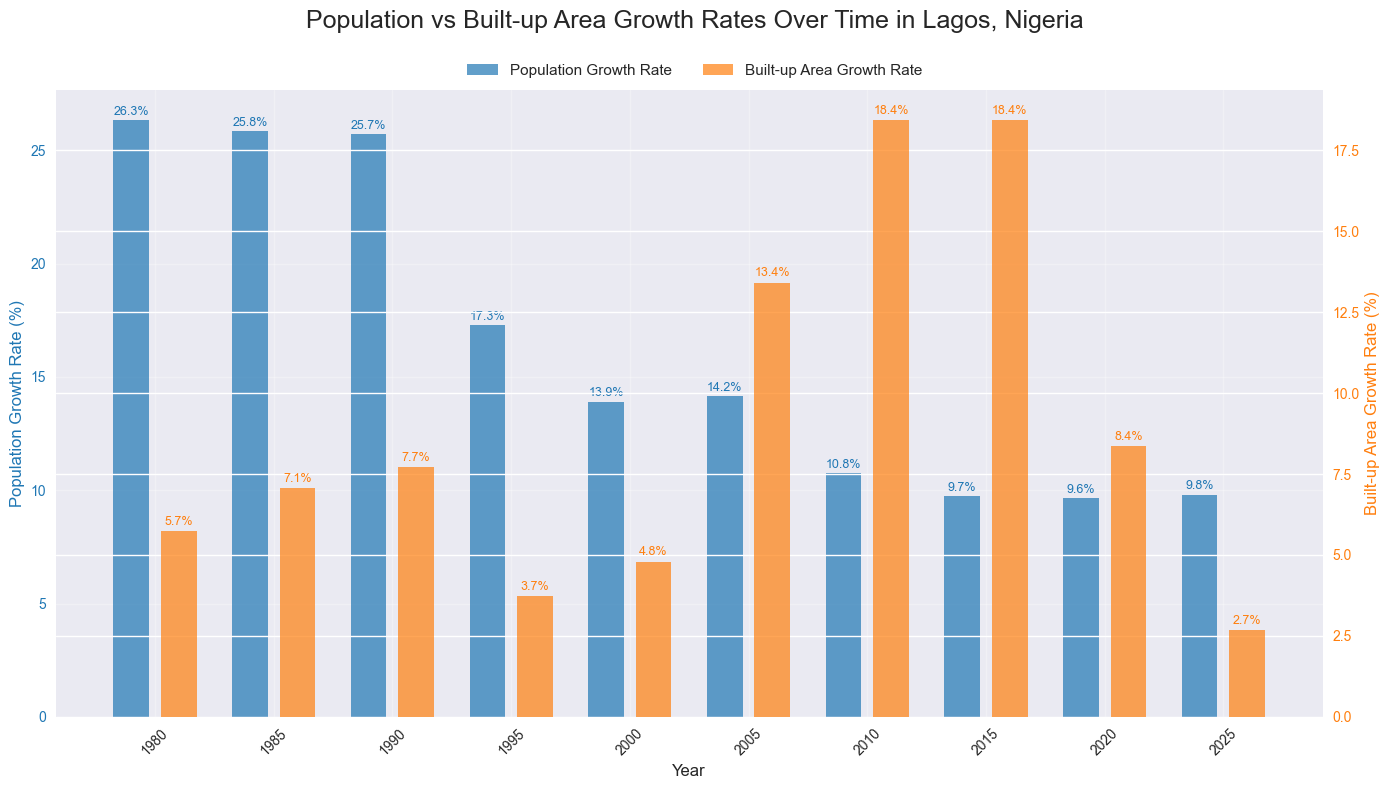

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dual_axis_growth_rates(growth_stats, savepath=None):
    """
    Create dual-axis bar chart for population and built-up area growth rates.
    Handles formatted and mixed-type growth_stats.
    """
    data_subset = growth_stats.copy()
    data_subset = data_subset[pd.to_numeric(data_subset['Year'], errors='coerce').notnull()]
    data_subset['Year'] = data_subset['Year'].astype(int)
    data_subset = data_subset[data_subset['Year'] > data_subset['Year'].min()]
    
    data_subset['Population_Growth_Rate_%'] = pd.to_numeric(data_subset['Population_Growth_Rate_%'], errors='coerce')
    data_subset['BuiltUp_Growth_Rate_%'] = pd.to_numeric(data_subset['BuiltUp_Growth_Rate_%'], errors='coerce')

    fig, ax1 = plt.subplots(figsize=(14, 8))
    offset = 1
    bar_width = 1.5

    color1 = 'tab:blue'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Population Growth Rate (%)', color=color1, fontsize=12)
    bars1 = ax1.bar(
        data_subset['Year'] - offset,
        data_subset['Population_Growth_Rate_%'],
        width=bar_width, color=color1, alpha=0.7,
        label='Population Growth Rate'
    )
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Built-up Area Growth Rate (%)', color=color2, fontsize=12)
    bars2 = ax2.bar(
        data_subset['Year'] + offset,
        data_subset['BuiltUp_Growth_Rate_%'],
        width=bar_width, color=color2, alpha=0.7,
        label='Built-up Area Growth Rate'
    )
    ax2.tick_params(axis='y', labelcolor=color2)

    for bar, value in zip(bars1, data_subset['Population_Growth_Rate_%']):
        if not np.isnan(value):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{value:.1f}%', ha='center', va='bottom', fontsize=9, color=color1)

    for bar, value in zip(bars2, data_subset['BuiltUp_Growth_Rate_%']):
        if not np.isnan(value):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{value:.1f}%', ha='center', va='bottom', fontsize=9, color=color2)

    ax1.set_xticks(data_subset['Year'])
    ax1.set_xticklabels(data_subset['Year'], rotation=45)

    # Title ABOVE the legend (on figure level)
    fig.suptitle('Population vs Built-up Area Growth Rates Over Time in Lagos, Nigeria', fontsize=18, y=0.98)

    # Legend just below the title
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.93),  # adjust lower if needed
        ncol=2,
        fontsize=11
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # leave space for suptitle + legend
    if savepath:
        plt.savefig(savepath)
    plt.show()
plot_dual_axis_growth_rates(
    growth_stats, savepath='../assets/barchart.png'
)

## 4. Mapping Functions

In [15]:
def plot_mollweide(data, variable, date, title, quantiles, threshold=None, ax=None, show_colorbar=True):
    """
    Plot data using Mollweide projection.
    """
    moll = ccrs.Mollweide()
    
    if ax is None:
        fig, ax = plt.subplots(
            figsize=(10, 7),
            dpi=150,
            subplot_kw={'projection': moll}
        )
    
    # Apply threshold if provided
    da = data[variable].sel(time=date)
    if threshold:
        da = da.where(da > threshold)
    
    # Plot the xarray data
    im = da.plot(
        ax=ax,
        transform=moll,
        cmap='viridis',
        levels=quantiles,
        add_colorbar=show_colorbar,
        cbar_kwargs={'orientation': 'horizontal', 'label': variable_labels[variable]} if show_colorbar else {}
    )
    
    # Add background features
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    return im

In [26]:
def plot_change(data, variable, year1=1975, year2=2025, k_quantiles=10, threshold=None, savepath=None):
    """
    Plot side-by-side comparison maps for two different years with shared legend.
    """
    date1 = f'{year1}-01-01'
    date2 = f'{year2}-01-01'
    
    # Get data for both years
    data1 = data[variable].sel(time=date1)
    data2 = data[variable].sel(time=date2)
    
    if threshold:
        data1 = data1.where(data1 > threshold)
        data2 = data2.where(data2 > threshold)
    
    # Calculate quantiles from combined data range
    combined_data = np.concatenate([data1.values.flatten(), data2.values.flatten()])
    combined_data = combined_data[~np.isnan(combined_data)]
    quantiles = np.quantile(combined_data, np.linspace(0, 1, k_quantiles + 1))
    
    # Create side-by-side plots
    moll = ccrs.Mollweide()
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 8),
        subplot_kw={'projection': moll}
    )
    
    # Plot first year
    plot_mollweide(data, variable, date1, f'{variable_labels[variable]}: {year1}', 
                   quantiles, threshold, ax=ax1, show_colorbar=False)
    
    # Plot second year
    im = plot_mollweide(data, variable, date2, f'{variable_labels[variable]}: {year2}', 
                        quantiles, threshold, ax=ax2, show_colorbar=False)

    ax1.set_ylim((780000, 867000.0))
    ax2.set_ylim((780000, 867000.0))
    
    # Add shared horizontal colorbar
    cbar = fig.colorbar(im, ax=[ax1, ax2], orientation='horizontal', 
                        fraction=0.05, pad=0.1, aspect=50)
        # Set quantile-based ticks and labels
    cbar.set_ticks(quantiles)
    cbar.set_ticklabels([f'{q:.1f}' for q in np.linspace(0, 1, k_quantiles + 1)])
    cbar.set_label(f'{variable_labels[variable]} (combined quantiles)', fontsize=12)
    plt.suptitle(f'{variable_labels[variable]} Comparison: {year1} vs {year2}', fontsize=16, y=0.95)
    if savepath:
        plt.savefig(savepath)
    plt.show()

In [31]:
def plot_addition(data, variable, year1, year2, threshold=None, savepath=None):
    """
    Plot the difference (addition) between two years showing added units per pixel.
    """
    date1 = f'{year1}-01-01'
    date2 = f'{year2}-01-01'
    
    data1 = data[variable].sel(time=date1)
    data2 = data[variable].sel(time=date2)
    
    if threshold:
        mask = (data1 > threshold) | (data2 > threshold)
        difference = (data2 - data1).where(mask)
    else:
        difference = data2 - data1
    
    # Create quantiles for difference data
    diff_values = difference.values.flatten()
    diff_values = diff_values[~np.isnan(diff_values)]
    
    if len(diff_values) > 0:
        max_abs = np.max(np.abs(diff_values))
        quantiles = np.linspace(-max_abs, max_abs, 11)
    else:
        quantiles = np.linspace(-1, 1, 11)
    
    # Create plot
    moll = ccrs.Mollweide()
    fig, ax = plt.subplots(
        #figsize=(12, 8),
        dpi=250,
        subplot_kw={'projection': moll}
    )
    
    # Plot difference data
    im = difference.plot(
        ax=ax,
        transform=moll,
        cmap='Reds',
        #levels=quantiles,
        add_colorbar=True,
        cbar_kwargs={'orientation': 'horizontal', 'label': f'{variable_labels[variable]} Added'}
    )
    
    # Add background features
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    ax.set_ylim((780000, 867000.0))
    ax.set_title(f'{variable_labels[variable]} Addition: {year2} - {year1}', fontsize=16)
    ax.axis('off')
    
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


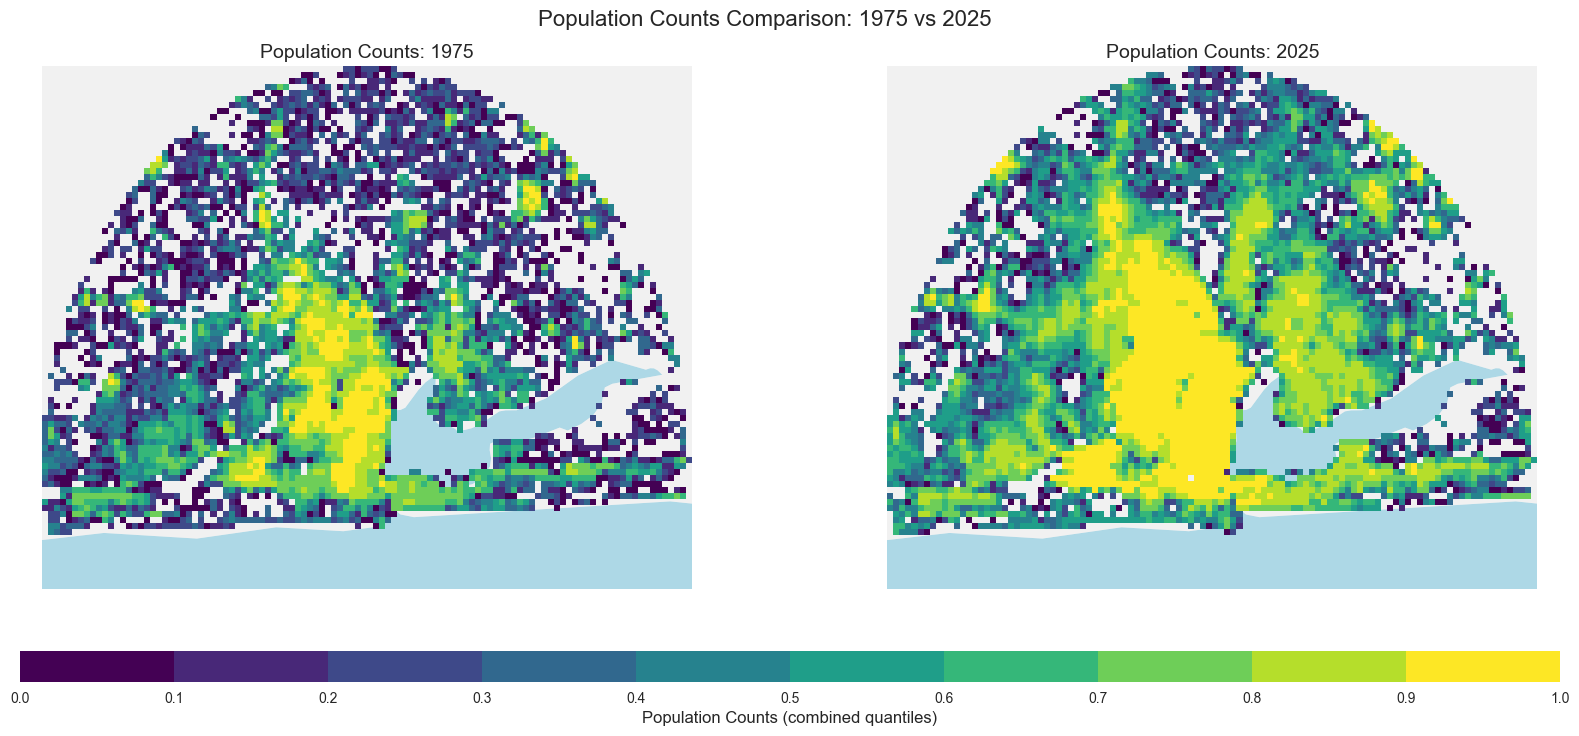

In [32]:
# Population comparison: 1975 vs 2025
plot_change(data, 'GHS_POP', year1=1975, year2=2025, k_quantiles=10, threshold=0.01, savepath='../assets/ghs_pop_comparison.png')

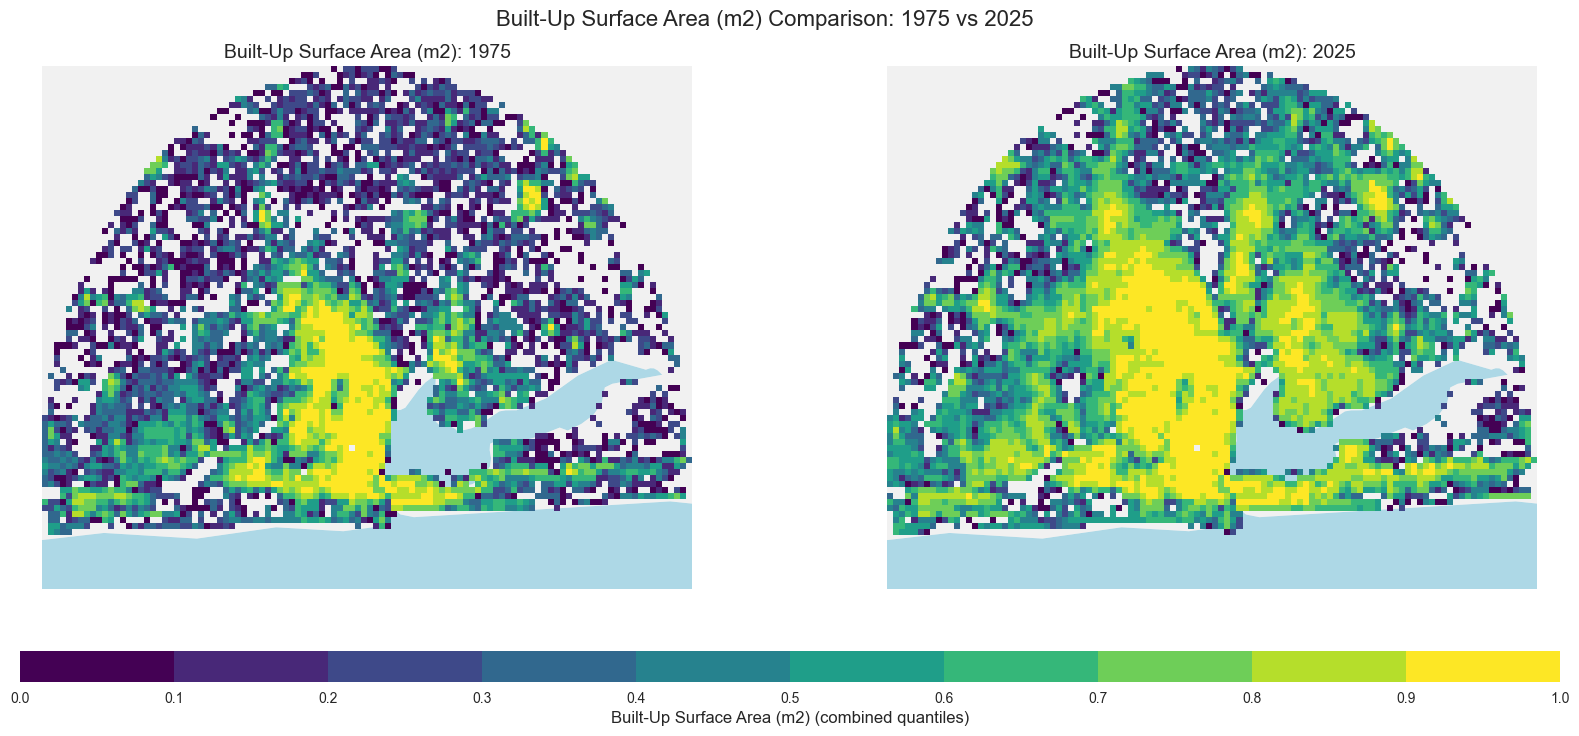

In [33]:
# Built-up area comparison: 1975 vs 2025
plot_change(data, 'GHS_BUILT', year1=1975, year2=2025, k_quantiles=10, threshold=0.01, savepath='../assets/ghs_built_comparison.png')

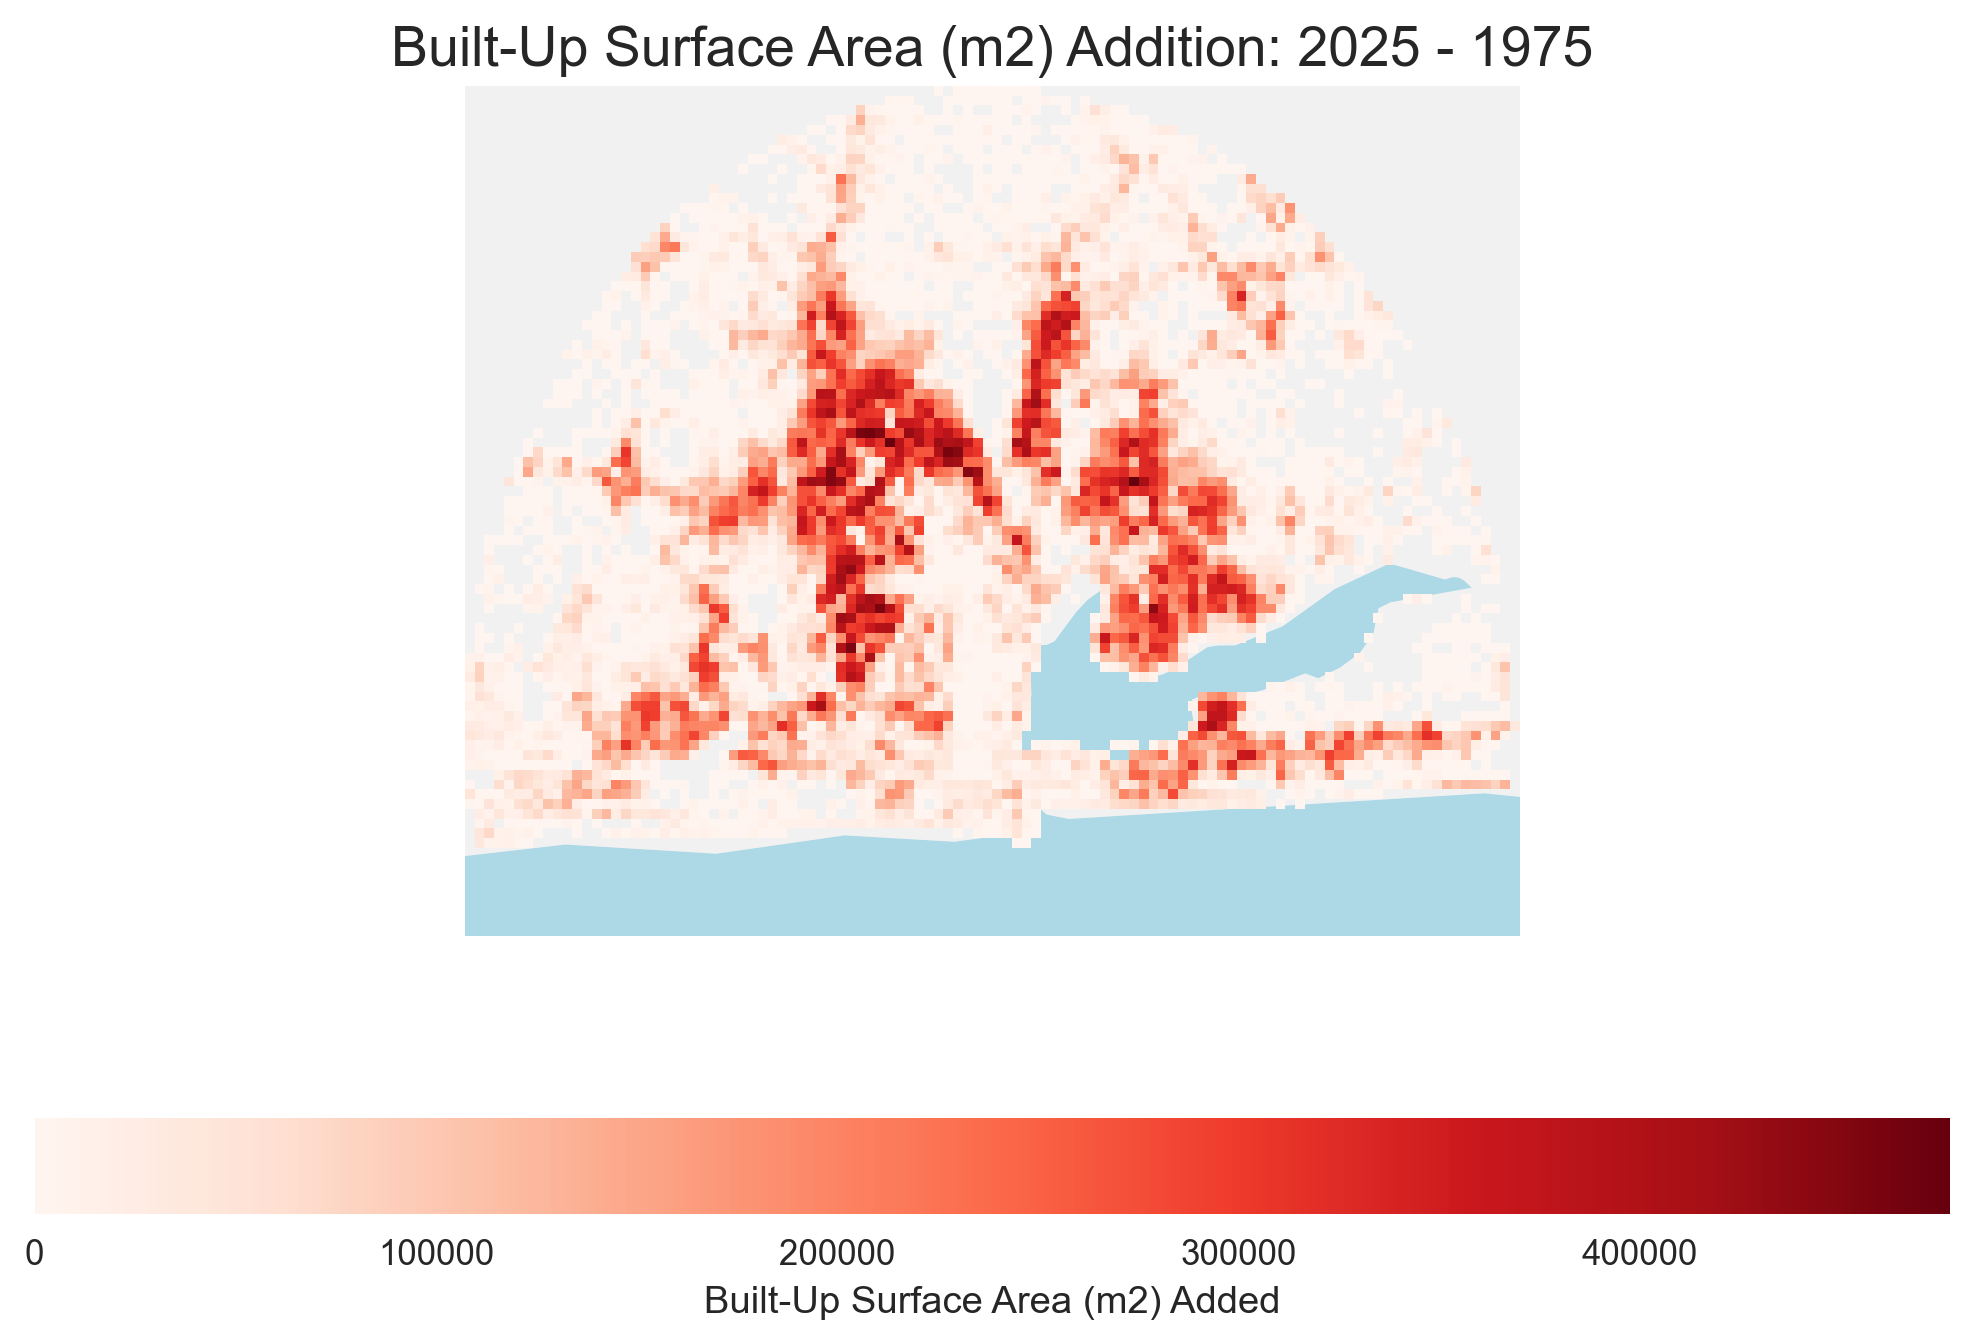

In [34]:
# Built-up area addition: 1975 to 2025
plot_addition(data, 'GHS_BUILT', year1=1975, year2=2025, threshold=0.01, savepath='../assets/ghs_built_addition.png')

In [35]:
ghs_smod = ghslpy.download(
    products=["GHS-SMOD"],
    epoch=epochs,
    resolution="1000m",
    region=buffered,
)

## 

In [37]:
vectors = ghslpy.vectorize(ghs_smod)

In [39]:
print(vectors.head().to_markdown())

|    | GHS_SMOD                        | geometry                                                                                                                                                                                                 | date       |   class_value | domain       |
|---:|:--------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|--------------:|:-------------|
|  0 | Rural cluster grid cell         | POLYGON ((3.217660653138162 6.994413796945866, 3.217626187922543 6.986302972149155, 3.2376737031120912 6.986302972149155, 3.237708383064257 6.994413796945866, 3.217660653138162 6.994413796945866))     | 1975-01-01 |            13 | Rural domain |
|  1 | Low Density Rural grid cell     | POLYGON ((3.1474262112458655 6.978192201224707, 3.147392577853242 6.970081484108726, 3.15741612

In [55]:
def smod_year_of_transition(gdf: gpd.GeoDataFrame, classification: str = "Urban Centre grid cell") -> gpd.GeoDataFrame:
    """
    Transform GHS-SMOD already vectorized data into a GeoDataFrame with year of transition for Urban Centre Grid Cells
    """
    gdf = gdf[gdf.GHS_SMOD == classification]
    gdf["year"] = pd.to_datetime(gdf["date"]).dt.year
    yearly = gdf.dissolve(by="year")
    yearly = yearly.sort_index()

    new_geometries = []
    past_union = None

    for year, row in yearly.iterrows():
        current_geom = row.geometry

        if past_union is not None:
            new_geom = current_geom.difference(past_union)
        else:
            new_geom = current_geom
        new_geometries.append({"year": year, "geometry": new_geom})

        past_union = (
            current_geom
            if past_union is None
            else past_union.union(current_geom)
        )

    incremental_gdf = gpd.GeoDataFrame(new_geometries, crs=gdf.crs)
    return incremental_gdf

In [56]:
yot = smod_year_of_transition(vectors)

/Users/jeronimoluza/Library/Caches/pypoetry/virtualenvs/ghslpy-mz3gmd9G-py3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


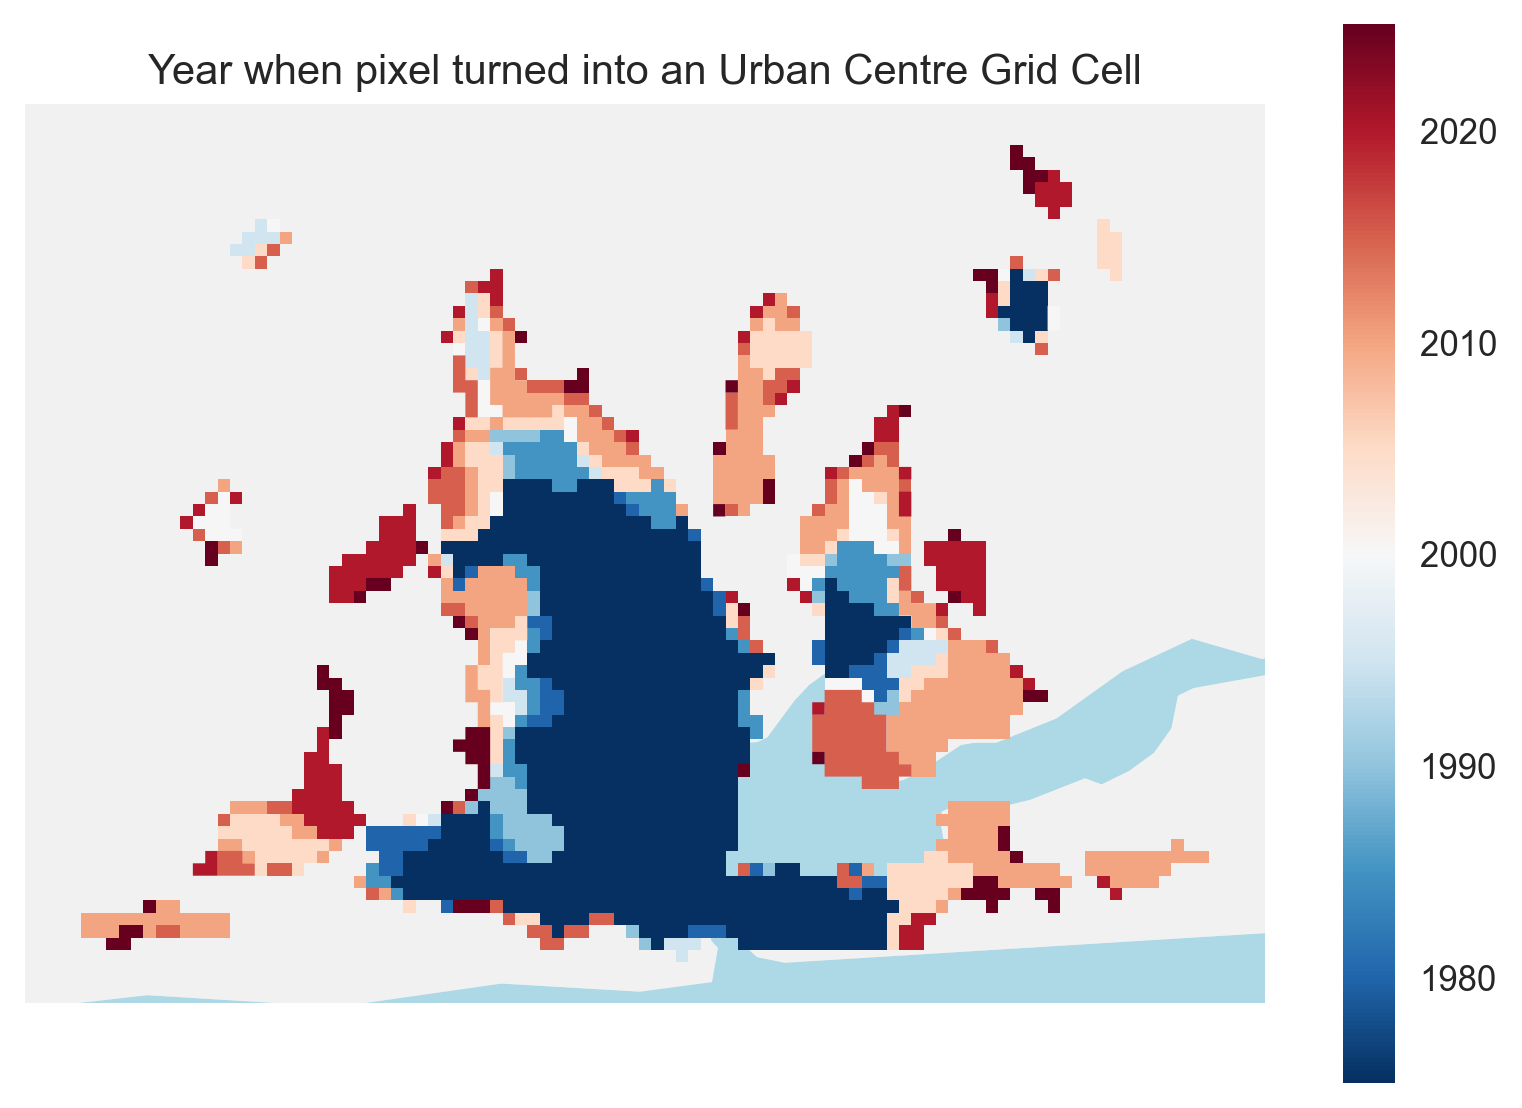

In [70]:
moll = ccrs.Mollweide()
fig, ax = plt.subplots(dpi=250, subplot_kw={"projection":moll})
yot.to_crs(moll).plot('year', cmap="RdBu_r", legend=True, ax = ax)
ax.set_title('Year when pixel turned into an Urban Centre Grid Cell')
ax.axis('off')
# Add background features
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
plt.savefig('../assets/smod_year_of_transition.png')
plt.show()